# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** *J*

**Names:**
* *Ann-Kristin Bergmann*
* *Nephele Aesopou*
* *Ewa Miazga*

---

#### Instructions

*This is a template for part 1 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

---

## 2.1 Exploration of real networks

#### Exercise 2.1

In [2]:
# Imports
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import collections
import numpy as np

In [3]:
# Function that loads the networks from the data folder
def load_data(file_name, comment, is_header):
    network = pd.read_csv(f'../data/{file_name}', comment = comment, header = is_header)
    network.columns = ['fromNode', 'toNode']
    return network

In [4]:
network1 = load_data('network1.csv', '#', None)
network1.head()

,fromNode,toNode
0,0,11932
1,1,5128
2,2,7008
3,3,10476
4,4,9671


In [5]:
def create_graph(network):
    G = nx.Graph()
    G = nx.from_pandas_edgelist(network, 'fromNode', 'toNode')
    return G

In [6]:
G = create_graph(network1)

In [7]:
# Get the number of edges and the number of nodes of the graph.
def graph_info(graph):
    num_edges = G.number_of_edges()
    num_nodes = G.number_of_nodes()
    return f'num of edges: {num_edges}, num of nodes: {num_nodes}'

In [8]:
graph_info(G)

'num of edges: 18584, num of nodes: 13033'

#### Exercise 2.2:  Node degree distribution

### *Initial Exploration of the node degrees*

In [9]:
def get_degrees_count(G):
    degree_sequence = sorted((val for (node, val) in G.degree()), reverse=False)
    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())
    return deg, cnt

# Given the graph, plot the node degree vs. its frequency in a log-log plot.
def display_degree_freq(G):
    deg, cnt = get_degrees_count(G)

    fig, ax = plt.subplots(ncols=1, figsize=(16, 4))
    plt.plot(np.log(deg), np.log(cnt), color='crimson', marker='.', zorder=2)
    ax.set_ylabel('degree frequency (log)')
    ax.set_xlabel('degree (log)')
    return plt

<module 'matplotlib.pyplot' from 'c:\\Users\\ewa.miazga\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\matplotlib\\pyplot.py'>

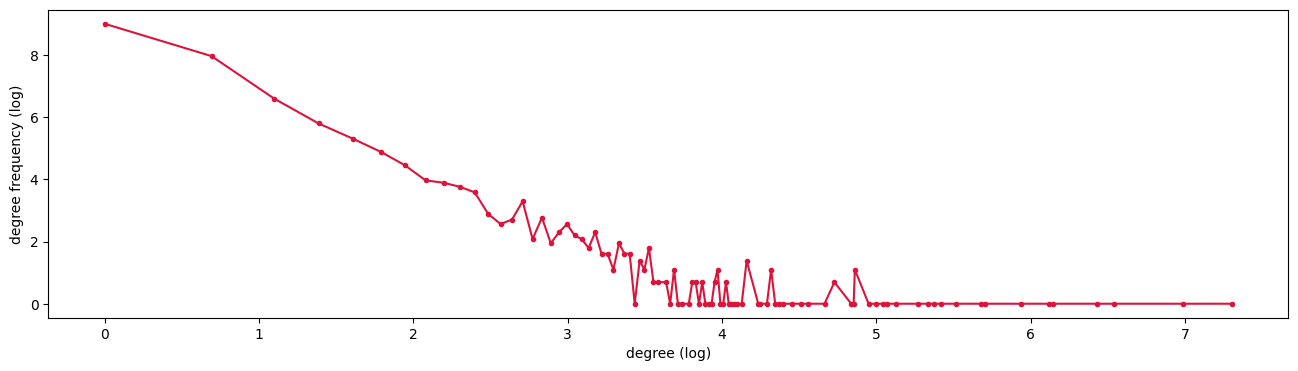

In [10]:
display_degree_freq(G)

In [11]:
# Plot the degree of the node vs. its cumulative frequency
def display_cum_degree_freq(G):
    deg, cnt = get_degrees_count(G)
    cum_deg = np.cumsum(deg)
    fig, ax = plt.subplots(ncols=1, figsize=(16, 4))
    plt.plot(cum_deg, cnt, color='crimson', marker='.', zorder=2)
    ax.set_ylabel('Cumulative degree frequency')
    ax.set_xlabel('degree')
    return plt

<module 'matplotlib.pyplot' from 'c:\\Users\\ewa.miazga\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\matplotlib\\pyplot.py'>

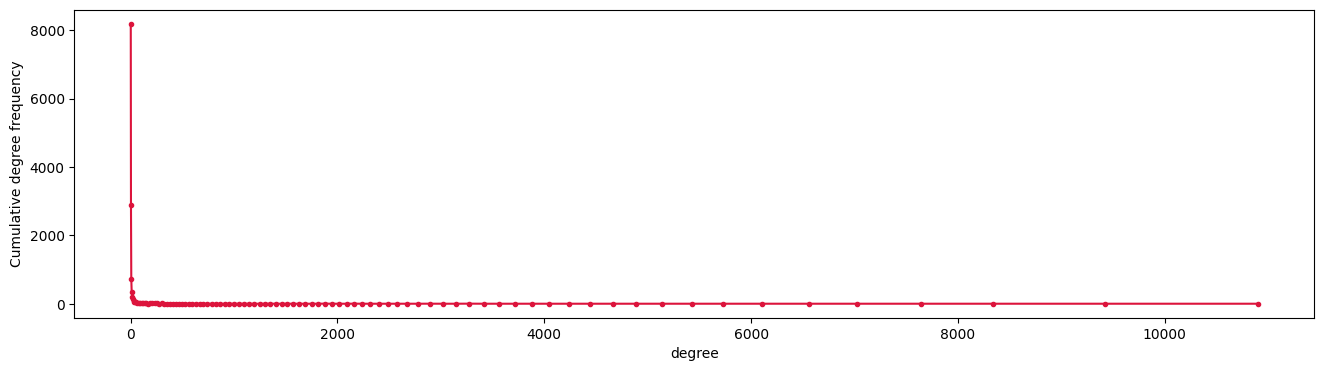

In [12]:
display_cum_degree_freq(G)
# This plot reminds us of the power law, hence we investigate further.


In [13]:
# Plot the degree vs. the probability that a node has greater or equal degree using log-log plot.
def display_power_law_plot(G):
    deg, cnt = get_degrees_count(G)
    #Compute the cumulative sum of the degree counts
    cum_degree_counts = np.cumsum(cnt)
    # number of nodes with degree >= x
    cum_freq = np.flip(cum_degree_counts)
    plt.loglog(deg, cum_freq)
    plt.xlabel("Node degree d")
    plt.ylabel("P(node has degree >= d)")


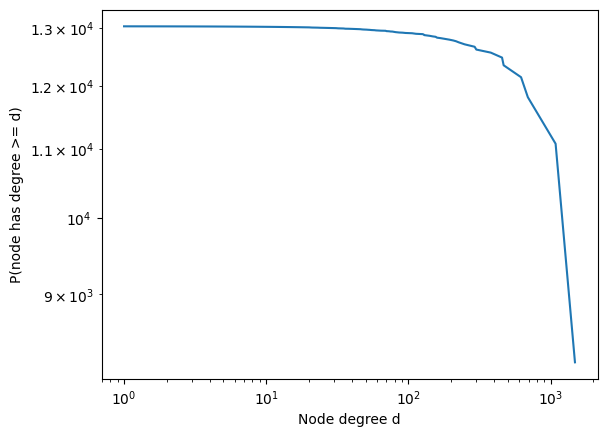

In [14]:
display_power_law_plot(G)

1. **What kind of plot do you think is useful for this task?**
We used line plots for this task. Moreover, because the degrees and their frequency have a very large range, we sometimes have to plot the log-log plot, to gain a more reprsentative understanding. For the second and third plots we also use the cumulative function.

2. **Can you list some of the properties of the degree distribution?**
 * From the first graph, we see that the log of the degrees and the log of the frequency is inversely proportional.
 * A great number of the nodes has degree 1.
 * An important graph property is the degree distribution function P(k), that describes the probability to find a node with k edges. Using the notion from the lectures, we plot the third graph and discover a well-known probability distribution shape, the power law

3. **Is it close to a well-known probability distribution? If so, provide an estimation of its parameter(s)?**
By the third plot, it looks like a power-law distribution. Its slope is equal to -γ .


In [15]:
# To run this you need to install powerlaw library.
import powerlaw

degree_sequence = sorted((val for (node, val) in G.degree()), reverse=False)
results=powerlaw.Fit(degree_sequence, discrete=True, estimate_discrete=False)

print('alpha = ',results.power_law.alpha)

Calculating best minimal value for power law fit
alpha =  2.1452776399099993


c:\Users\ewa.miazga\AppData\Local\Programs\Python\Python39\lib\site-packages\powerlaw.py:1195: RuntimeWarning: divide by zero encountered in scalar divide
  C = 1.0/C
c:\Users\ewa.miazga\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\_optimize.py:863: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


Using the powerlaw package we get the slope parameter of our distribution. In this package, alpha is equal to gamma, the slope.
Gamma = 2.145

#### Exercise 2.3: Giant component

In [16]:
def calc_connected_components_num(G):
    return nx.number_connected_components(G)

In [17]:
print("Number of connected components in G is", calc_connected_components_num(G))

Number of connected components in G is 192


In [18]:
# Calculate the average degree (c) of the graph. Return TRUE, i.e. the graph has a giant component, if (c>1).
def is_giant_component(G):
    deg, cnt = get_degrees_count(G)
    np_cnt = np.array(cnt)
    np_deg = np.array(deg)
    c = sum(np_cnt * np_deg) / len(G)
    print(f'Average graph degree: {c}')
    return c > 1

def giant_component_info(G):
    if is_giant_component(G):
        Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
        G0 = G.subgraph(Gcc[0])
        print("The giant component is a", G0)
    else:
        print("There is no giant component")

In [19]:
giant_component_info(G)

Average graph degree: 2.8518376429064682
The giant component is a Graph with 12576 nodes and 18317 edges


#### Exercise 2.4: Short paths & Small-worlds

In [20]:
def get_avg_paths_length(G):
    avg_length = []
    for C in (G.subgraph(c).copy() for c in nx.connected_components(G)):
        avg_length.append(nx.average_shortest_path_length(C))
    return sum(avg_length) / len(avg_length)

In [21]:
# Average length of connection between every two nodes in graph
get_avg_paths_length(G)

1.1072818079387936

In [22]:
def get_shortest_paths(G):
    shortest_paths = list(nx.shortest_path_length(G))
    paths_list = []
    for node in shortest_paths:
        temp = [value for value in node[1].values()]
        paths_list.extend(temp)
    return paths_list

In [23]:
# Assign to paths_list the list with shortest paths for any node in G.
paths_list = get_shortest_paths(G)

In [24]:
# Distribution of path lenghts between any two nodes in the network.
# Plot the length of the shortest path between two nodes and the frequency of that lenght arising.
def display_shortest_paths_dist(paths_list):
    degreeCount = collections.Counter(paths_list)
    deg, cnt = zip(*degreeCount.items())

    fig, ax = plt.subplots(ncols=1, figsize=(16, 4))
    ax.bar(deg, cnt)
    ax.set_ylabel('count (10^7)')
    ax.set_xlabel('shortest path length')
    return plt

<module 'matplotlib.pyplot' from 'c:\\Users\\ewa.miazga\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\matplotlib\\pyplot.py'>

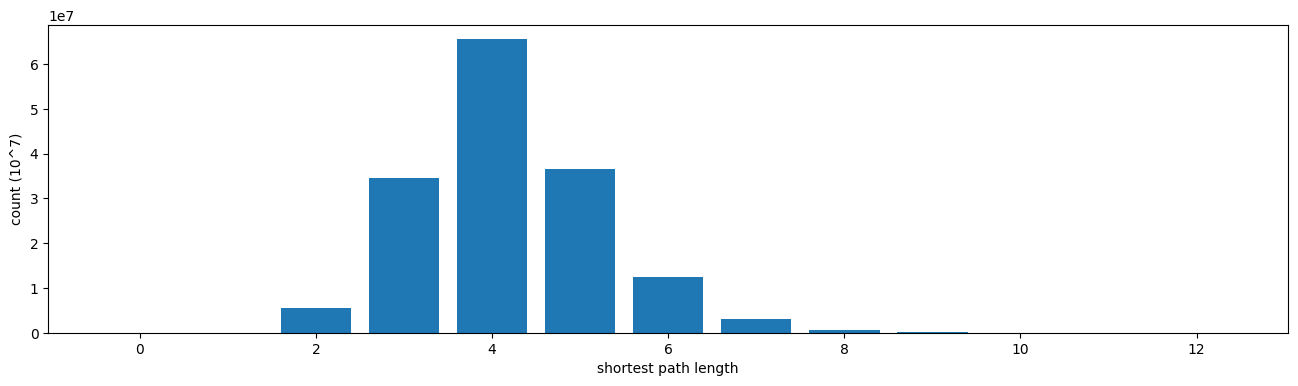

In [25]:
display_shortest_paths_dist(paths_list)

In [26]:
# Find the average number of nodes reachable within a distance r of any other node in the network.
def reachable_r(r, paths_list):
    how_many = 0
    reachable = [1 for node in paths_list if node <=r]
    return (sum(reachable) / len(paths_list)) * 100

In [27]:
print("Average # of noder reachable within distance=2 is", reachable_r(2, paths_list))
print("Average # of noder reachable within distance=6 is", reachable_r(6, paths_list))
print("Average # of noder reachable within distance=10 is", reachable_r(10, paths_list))

Average # of noder reachable within distance=2 is 3.458302466620528
Average # of noder reachable within distance=6 is 97.69460707504733
Average # of noder reachable within distance=10 is 99.99949417402605


**Do you think that network1 is a small-world?**
According to the above, we can agree with the theory of Duncan Watts, relating to Small Worlds. It is clear that 98% of the nodes in the graph are reachable within a distance of 6 edges = "six degrees of separation".

#### Exercise 2.5: Network comparison

In [28]:
network2 = load_data('network2.csv', '#', None)
network2.head()

,fromNode,toNode
0,135627,135630
1,135627,135623
2,135627,135625
3,135627,135626
4,137038,137040


**Properties of previous network**

In [29]:
# Create the graph of second network
G2 = create_graph(network2)

# Calculate num of edges and nodes in the graph
graph_info(G2)

'num of edges: 18584, num of nodes: 13033'

<module 'matplotlib.pyplot' from 'c:\\Users\\ewa.miazga\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\matplotlib\\pyplot.py'>

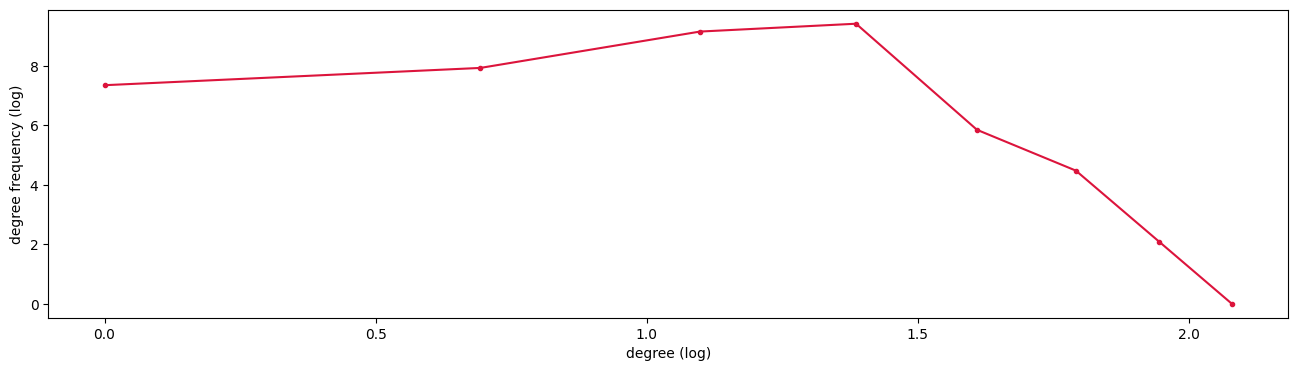

In [30]:
# Distribution of degrees in the network
display_degree_freq(G2)

In [31]:
# Draw the graph
#draw_graph(G2)

In [32]:
# Number of connected components in graph
print("Number of connected components in G is", calc_connected_components_num(G2))

Number of connected components in G is 5


In [33]:
# Find giant component of G2 and show its properties, if it exists.
giant_component_info(G2)

Average graph degree: 3.2790294627383014
The giant component is a Graph with 26481 nodes and 43437 edges


In [34]:
# Average length of connection between every two nodes in graph
get_avg_paths_length(G2)

21.66007803486037

In [35]:
del paths_list

In [36]:
paths_list_G2 = get_shortest_paths(G2)


<module 'matplotlib.pyplot' from 'c:\\Users\\ewa.miazga\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\matplotlib\\pyplot.py'>

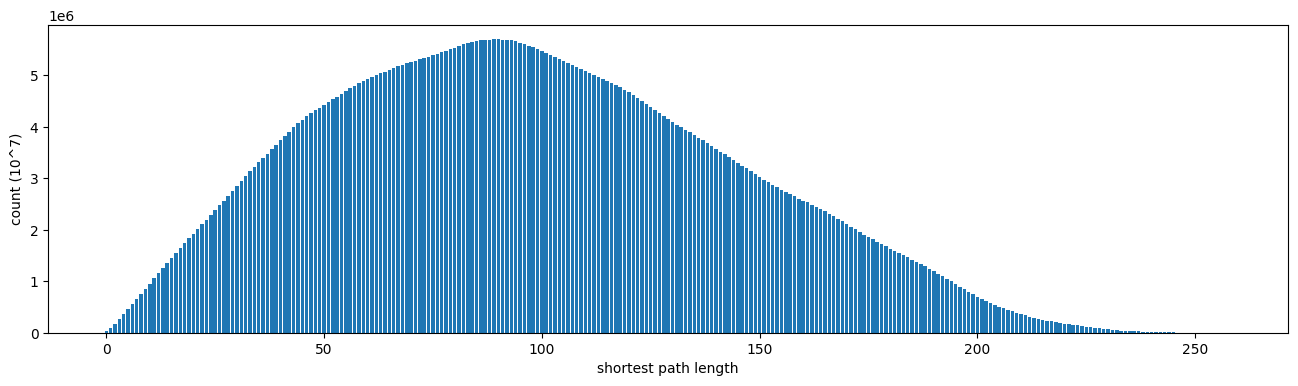

In [37]:
display_shortest_paths_dist(paths_list_G2)

In [38]:
print("Average # of noder reachable within distance=2 is", reachable_r(2, paths_list_G2))
print("Average # of noder reachable within distance=6 is", reachable_r(6, paths_list_G2))
print("Average # of noder reachable within distance=10 is", reachable_r(10, paths_list_G2))

Average # of noder reachable within distance=2 is 0.040658550789304464
Average # of noder reachable within distance=6 is 0.2727144386679902
Average # of noder reachable within distance=10 is 0.7305704823513104


#### Exercise 2.6: Network identification


We believe that the main distinction is the number of connected components and the degree distribution. 

We assume that the network with the less connected components, Network 2, is the New York city road map, as it is almost always possible to go from one road to another. Also the average node degrees is around three, which makes sense as an intersection usually has three to four roads "incident" to it and cannot have many more. Finally, average path length is around 22, which agrees with our intuition that these are the roads of NY. To get to an other intersection you must sometimes take a longer way around.

On the other hand, the routers of the Internet are usually not physically connected to one another. Hence, in Network 1, the number of connected components is large (192 compared to 5!) and each component maybe represents a neighbourhood/house in which the routers are physically connected. The average degree of the nodes is around 2.9 which is realistic because most of the devices are wirelessly conencted to the internet and physical connections are very few. Also, the average shortest path length is around 1 which confirms the fact that most of the routers within the connected components are connected through an edge.